Calculando scores para diferentes números de clusters...


C:\Users\cmigu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\cmigu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\cmigu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\cmigu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

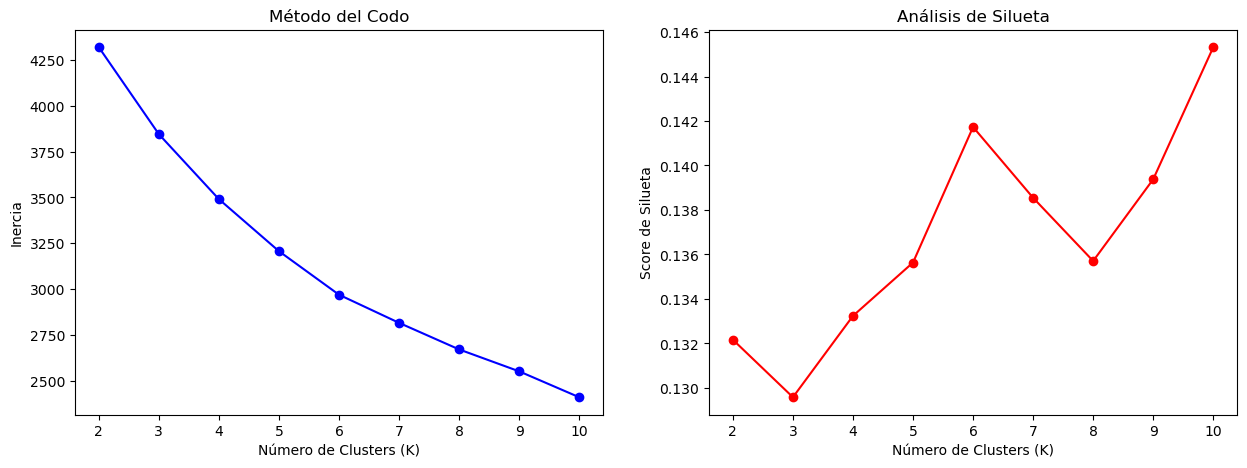

Entrenando el modelo K-Means con 6 clusters...

Tabla con la columna de cluster añadida:
             timestamp      temp_1      temp_2      temp_3     pres_1  \
0  2025-01-01 00:00:00  152.483571  149.308678  153.238443  32.284545   
1  2025-01-01 00:01:00  148.829315  157.896064  153.837174  29.295788   
2  2025-01-01 00:02:00  147.682912  147.671351  151.209811  27.130080   
3  2025-01-01 00:03:00  147.188562  144.935844  151.571237  28.637964   
4  2025-01-01 00:04:00  157.328244  148.871118  150.337641  27.862878   

      pres_2  cluster  
0  29.648770        1  
1  30.813840        3  
2  27.412623        4  
3  27.881544        2  
4  29.183426        0  

Distribución de puntos por cluster:
cluster
1    199
3    183
0    160
2    159
5    153
4    146
Name: count, dtype: int64
--- Perfiles de los Clusters (Valores Promedio de Sensores) ---
             temp_1      temp_2      temp_3     pres_1     pres_2
cluster                                                          
0      

C:\Users\cmigu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\cmigu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [9]:
import os
os.environ["OMP_NUM_THREADS"] = '16'
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# --- Código para cargar y pivotar los datos ---
db_file_path = 'planta_quimica.db'
conn = sqlite3.connect(db_file_path)
query = """
    SELECT
        timestamp,
        MAX(CASE WHEN sensor_id = 'temp_1' THEN valor END) AS temp_1,
        MAX(CASE WHEN sensor_id = 'temp_2' THEN valor END) AS temp_2,
        MAX(CASE WHEN sensor_id = 'temp_3' THEN valor END) AS temp_3,
        MAX(CASE WHEN sensor_id = 'pres_1' THEN valor END) AS pres_1,
        MAX(CASE WHEN sensor_id = 'pres_2' THEN valor END) AS pres_2
    FROM
        lecturas_sensores
    GROUP BY
        timestamp;
"""
df_ancho = pd.read_sql_query(query, conn)
conn.close()
# ------------------------------------------------

# 1. Preparar los datos para el clustering
#    Nos quedamos solo con las columnas numéricas y las estandarizamos
features = df_ancho.drop('timestamp', axis=1)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


# 2. Calcular Codo y Silueta para diferentes valores de K
k_values = range(2, 11) # Probaremos de 2 a 10 clusters
inertia_values = []
silhouette_values = []

print("Calculando scores para diferentes números de clusters...")
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_scaled)
    
    # Para el método del codo
    inertia_values.append(kmeans.inertia_)
    
    # Para el análisis de silueta
    silhouette_values.append(silhouette_score(features_scaled, kmeans.labels_))

# 3. Graficar los resultados
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico del Codo
ax1.plot(k_values, inertia_values, 'bo-')
ax1.set_title('Método del Codo')
ax1.set_xlabel('Número de Clusters (K)')
ax1.set_ylabel('Inercia')

# Gráfico de Silueta
ax2.plot(k_values, silhouette_values, 'ro-')
ax2.set_title('Análisis de Silueta')
ax2.set_xlabel('Número de Clusters (K)')
ax2.set_ylabel('Score de Silueta')

plt.show()

# 1. Crear y entrenar el modelo K-Means final con K=6
print("Entrenando el modelo K-Means con 6 clusters...")
kmeans_final = KMeans(n_clusters=6, random_state=42, n_init=10)
kmeans_final.fit(features_scaled)

# 2. Añadir las etiquetas del cluster a nuestra tabla original
df_ancho['cluster'] = kmeans_final.labels_

# 3. Mostrar las primeras filas con la nueva columna 'cluster'
print("\nTabla con la columna de cluster añadida:")
print(df_ancho.head())

# 4. Contar cuántos puntos hay en cada cluster
print("\nDistribución de puntos por cluster:")
print(df_ancho['cluster'].value_counts())

# 1. Seleccionar solo las columnas numéricas antes de agrupar
df_numerico = df_ancho.drop('timestamp', axis=1)

# 2. Agrupar por la columna 'cluster' y calcular el promedio
cluster_profiles = df_numerico.groupby('cluster').mean()

# 3. Imprimir la tabla de perfiles
print("--- Perfiles de los Clusters (Valores Promedio de Sensores) ---")
print(cluster_profiles)

# 1. Entrenar el modelo final con K=6
kmeans_final = KMeans(n_clusters=6, random_state=42, n_init=10)
kmeans_final.fit(features_scaled)

# 2. Calcular la distancia de cada punto al centroide de su cluster
#    Esto nos da una "puntuación de anomalía"
distancias = kmeans_final.transform(features_scaled)
distancia_minima = np.min(distancias, axis=1)
df_ancho['distancia_anomalia'] = distancia_minima

# 3. Ordenar el DataFrame para encontrar las lecturas más anómalas
df_anomalias = df_ancho.sort_values(by='distancia_anomalia', ascending=False)

# 4. Mostrar las 5 lecturas más anómalas
print("--- TOP 5 LECTURAS MÁS ANÓMALAS DETECTADAS ---")
print(df_anomalias.head(5))